In [11]:
import collections
import time
import itertools
import re

import pandas as pd
import numpy as np
import networkx as nx

#For plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
def listify(stringOfIDs):
    """Makes a string of IDs to a list"""
    stringOfIDs = str(stringOfIDs)
    lst = stringOfIDs[1:-1]
    lst = lst.split(", ")
    lst = [l[1:-1] for l in lst]
    
    if "" in lst:
        return None
    
    return lst

def listify_regex(string_of_ids):
    """Make a string of IDs to a list."""
    return re.sub("[^\w]", " ",  string_of_ids).split()


#Some function definitions
def _get_interfering_stations_fast(stationID, stationSet, interferenceConstraints):
    """Find the set of interfering stations in a given set of stations"""
    stationCriteria = interferenceConstraints["targetID"] == stationID
    tmpInterferenceConstraints = interferenceConstraints.loc[stationCriteria, "interferingIDs"]
    interferingStations = set([station for lst in tmpInterferenceConstraints.values if lst\
                               for station in lst])
    interferingStations = interferingStations.intersection(set(stationSet))

    return interferingStations


def checkGraph(G, constraints):
    """Check whether a graph has been created correctly"""
    stationSet = G.nodes
    for station in stationSet:
        interferingStations = _get_interfering_stations_fast(station, stationSet, constraints)
        if interferingStations.issubset(stationSet) == False:
            print("Something went wrong")
            print("Station: ", station, "\n Set: ", stationSet)
            return False
            
    return True          

In [3]:
path_constraints = "/Users/haakonhr/station-repacking/data/interim/interference_constraints_pruned.csv"
path_domains = "/Users/haakonhr/station-repacking/data/interim/domains_pruned.csv"

min_channel = 14
max_channel = 36

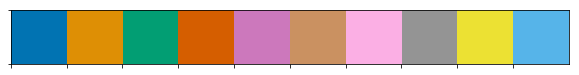

In [10]:
current_palette = sns.color_palette("colorblind", 10)
sns.set_palette(current_palette)
sns.palplot(current_palette)

In [12]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rc('text', usetex=True)
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
mpl.rcParams.update({'font.size': 13})

# The US interference graph

This section creates and studies the whole interference graph, considering all channels

In [4]:
column_names = ["interferenceType", "targetChannel", "interferingChannel", "targetID", "interferingIDs"]
raw_constraints = pd.read_table("../data/raw/Interference_Paired.csv", header=None, names=["interferenceType"])

#Manipulate so that the interferingIDs become a list
raw_constraints[column_names] = raw_constraints.interferenceType.str.split(",", n=4, expand=True)
raw_constraints.loc[:, "targetID"] = raw_constraints.loc[:, "targetID"].apply(str)
raw_constraints.loc[: ,"interferingIDs"] = raw_constraints.loc[:, "interferingIDs"].apply(lambda x: listify_regex(x) if x else None)

raw_constraints.head()

interferenceType targetChannel interferingChannel targetID  \
0               CO             2                  2       87   
1               CO             2                  2      125   
2               CO             2                  2      126   
3               CO             2                  2      131   
4               CO             2                  2      144   

                                      interferingIDs  
0  [38214, 50194, 50205, 66414, 72361, 79258, 86532]  
1  [126, 10032, 14040, 17683, 18287, 20476, 22685...  
2  [125, 14040, 18287, 20476, 22685, 23074, 24514...  
3  [4108, 5802, 6601, 6744, 7726, 7727, 9881, 100...  
4  [148, 749, 6669, 8564, 9754, 9781, 10188, 1024...

In [5]:
raw_constraints.dtypes

interferenceType      object
targetChannel         object
interferingChannel    object
targetID              object
interferingIDs        object
dtype: object

In [6]:
# check for strange values
for row in raw_constraints.itertuples():
    if not row.targetID.isdigit():
        print(row.targetID)
    
    if not row.targetChannel.isdigit():
        print(row.targetChannel)
        
    if not row.interferingChannel.isdigit():
        print(row.interferingChannel)
        
    if row.interferingIDs:
        for station in row.interferingIDs:
            if not station.isdigit():
                print(station)

The check is fine. There are no strange values in the dataframe.

In [7]:
raw_station_set = set(raw_constraints["targetID"].unique())
len(raw_station_set)

2990

In [8]:
#Create edge set
raw_E = set()
cnt_isolated_stations = 0
for station in raw_station_set:
    interfering_stations = _get_interfering_stations_fast(station, raw_station_set, raw_constraints)
    if not interfering_stations:
        
        cnt_isolated_stations += 1
    else:
        for interferingStation in interfering_stations:
            raw_E.add((station, interferingStation)) #The graph is the same, but we want both orders in the edge set
            
len(raw_E)

132080

There are 132080 edges in the complete interference graph.

In [13]:
cnt_isolated_stations

81

In [12]:
non_isolated_stations = set()
for edge in raw_E:
    for station in edge:
        non_isolated_stations.add(station)
        
isolated_stations = raw_station_set - non_isolated_stations
len(isolated_stations)

81

There are 81 isolated station, counted by two different methods, i.e. stations that do not participate in any interference constraints.

In [14]:
G_raw = nx.Graph()
G_raw.add_nodes_from(raw_station_set)
G_raw.add_edges_from(raw_E)

In [16]:
cc_dict = dict()
cnt_nodes = 0

index_cnt = 0
ccs = (G_raw.subgraph(cc) for cc in nx.connected_components(G_raw))
for cc in ccs:
    cnt_nodes += nx.number_of_nodes(cc)
    cc_dict[index_cnt] = {"density": nx.density(cc),
                          "size": nx.number_of_nodes(cc),
                          "stations": set(cc)}
    index_cnt += 1
    
# A quick consistency check    
if cnt_nodes != len(raw_station_set):
    raise ValueError("Some stations went missing")

cc_df = pd.DataFrame.from_dict(cc_dict, orient="index")
cc_df = cc_df.sort_values(by="size", ascending=False)
cc_df.head(10)

density  size                                           stations
0   0.021715  2423  {1000155, 10645, 61251, 35855, 36841, 52408, 8...
9   0.891121    44  {54443, 4077, 3001, 53859, 19776, 2245, 73901,...
3   0.329768    34  {1500137, 1000077, 1500132, 1000045, 1000050, ...
20  0.940711    23  {34445, 664, 27969, 26428, 3246, 36846, 64548,...
4   0.329004    22  {1000028, 1000022, 1500005, 1000018, 1000013, ...
36  1.000000    21  {1500345, 1500343, 1500356, 1500353, 1500361, ...
37  0.346405    18  {1500110, 1000074, 1500145, 1500295, 1500144, ...
29  1.000000    16  {1500066, 1500159, 1500069, 1500161, 1500164, ...
34  1.000000    16  {1500193, 1500195, 1500204, 1500200, 1500196, ...
22  0.836364    11  {1000085, 1500317, 1500253, 1500319, 1500086, ...

In [17]:
cc_df["type"] = cc_df.loc[:, ["density", "size"]].apply(lambda row: "isolated" if row["size"] == 1 \
                                                        else ("clique" if row["density"] == 1 else "no_type"), axis=1)

In [23]:
cc_df[cc_df["type"] == "no_type"]

density  size                                           stations  \
0    0.021715  2423  {1000155, 10645, 61251, 35855, 36841, 52408, 8...   
9    0.891121    44  {54443, 4077, 3001, 53859, 19776, 2245, 73901,...   
3    0.329768    34  {1500137, 1000077, 1500132, 1000045, 1000050, ...   
20   0.940711    23  {34445, 664, 27969, 26428, 3246, 36846, 64548,...   
4    0.329004    22  {1000028, 1000022, 1500005, 1000018, 1000013, ...   
37   0.346405    18  {1500110, 1000074, 1500145, 1500295, 1500144, ...   
22   0.836364    11  {1000085, 1500317, 1500253, 1500319, 1500086, ...   
38   0.266667    10  {1500064, 1500176, 1500271, 1500091, 1500043, ...   
5    0.488889    10  {1500247, 1500042, 1500245, 1500177, 1500093, ...   
27   0.904762     7  {1500316, 1000067, 1000058, 1000100, 1000099, ...   
102  0.733333     6  {1500150, 1500074, 1500151, 1000053, 1500075, ...   
56   0.800000     6  {1500174, 1500273, 1500274, 1500275, 1000081, ...   
69   0.666667     4               {1000057, 1500062, 1500063, 1500208}   
65   0.666667     4               {1000080, 1000065, 1500058, 1500057}   
81   0.666667     4               {1000030, 1000035, 1000333, 1000031}   
71   0.666667     3                        {1500097, 1500297, 1000072}   
28   0.666667     3                        {1500103, 1500052, 1500209}   

        type  
0    no_type  
9    no_type  
3    no_type  
20   no_type  
4    no_type  
37   no_type  
22   no_type  
38   no_type  
5    no_type  
27   no_type  
102  no_type  
56   no_type  
69   no_type  
65   no_type  
81   no_type  
71   no_type  
28   no_type

In [22]:
cc_df.head()

density  size                                           stations     type
0   0.021715  2423  {1000155, 10645, 61251, 35855, 36841, 52408, 8...  no_type
9   0.891121    44  {54443, 4077, 3001, 53859, 19776, 2245, 73901,...  no_type
3   0.329768    34  {1500137, 1000077, 1500132, 1000045, 1000050, ...  no_type
20  0.940711    23  {34445, 664, 27969, 26428, 3246, 36846, 64548,...  no_type
4   0.329004    22  {1000028, 1000022, 1500005, 1000018, 1000013, ...  no_type

In [142]:
cc_df[cc_df["type"] == "clique"]

density  size                                           stations    type
32       1.0    21  {1500353, 1500358, 1500345, 1500355, 1500351, ...  clique
11       1.0    16  {1500191, 1500197, 1500190, 1500194, 1500201, ...  clique
9        1.0    16  {1500066, 1500162, 1500068, 1500159, 1500166, ...  clique
21       1.0     9  {1500429, 1500426, 1500425, 1500424, 1500422, ...  clique
58       1.0     8  {35655, 21488, 49632, 13815, 25221, 10173, 787...  clique
67       1.0     7  {1500374, 1500377, 1500375, 1500376, 1500378, ...  clique
104      1.0     7  {1000060, 1500119, 1500123, 1500118, 1500120, ...  clique
82       1.0     6  {1500312, 1500028, 1500311, 1500073, 1500072, ...  clique
66       1.0     6         {13813, 64597, 49621, 64596, 20015, 69315}  clique
73       1.0     6  {1500324, 1500326, 1500329, 1500327, 1500325, ...  clique
71       1.0     5      {1500306, 1500307, 1500308, 1500304, 1500305}  clique
25       1.0     5      {1500153, 1500155, 1500152, 1500156, 1500154}  clique
51       1.0     5                 {36914, 34846, 37103, 64544, 4146}  clique
23       1.0     5      {1500266, 1500265, 1500269, 1500267, 1500268}  clique
34       1.0     5      {1500172, 1500169, 1500168, 1500170, 1500171}  clique
106      1.0     5      {1500139, 1500142, 1500140, 1500138, 1500141}  clique
40       1.0     4               {1500289, 1500286, 1500287, 1500288}  clique
3        1.0     4               {1500370, 1500372, 1500369, 1500371}  clique
83       1.0     4               {1000119, 1000118, 1000120, 1000121}  clique
54       1.0     4               {1500096, 1500049, 1500050, 1500051}  clique
46       1.0     4               {1500186, 1500185, 1500188, 1500187}  clique
42       1.0     4               {1500222, 1500219, 1500220, 1500221}  clique
103      1.0     4               {1500215, 1500216, 1500218, 1500217}  clique
24       1.0     4               {1500114, 1500117, 1500115, 1500116}  clique
16       1.0     4               {1000106, 1500263, 1500264, 1500262}  clique
37       1.0     3                        {1500290, 1500292, 1500291}  clique
63       1.0     3                        {1500055, 1500054, 1500053}  clique
84       1.0     3                        {1500046, 1500045, 1500047}  clique
20       1.0     3                        {1500205, 1500206, 1500207}  clique
117      1.0     3                        {1000076, 1000075, 1500259}  clique
..       ...   ...                                                ...     ...
108      1.0     2                                 {1000084, 1500104}  clique
89       1.0     2                                 {1500227, 1000086}  clique
92       1.0     2                                 {1000227, 1000226}  clique
128      1.0     2                                 {1500331, 1500333}  clique
95       1.0     2                                 {1500322, 1000109}  clique
122      1.0     2                                 {1500449, 1500445}  clique
96       1.0     2                                 {1500182, 1500181}  clique
123      1.0     2                                 {1500402, 1500403}  clique
97       1.0     2                                 {1500235, 1500234}  clique
134      1.0     2                                 {1500400, 1500399}  clique
109      1.0     2                                 {1000082, 1000083}  clique
107      1.0     2                                 {1500210, 1500211}  clique
75       1.0     2                                 {1500255, 1500256}  clique
93       1.0     2                                 {1500302, 1500303}  clique
85       1.0     2                                 {1500434, 1500433}  clique
74       1.0     2                                      {8651, 13814}  clique
19       1.0     2                                 {1500089, 1500090}  clique
47       1.0     2                                 {1500278, 1500279}  clique
41       1.0     2                                 {1500243, 1500242}  clique
36       1.0     2         

In [76]:
cc_df.loc[:, "type"].value_counts()

isolated    81
clique      73
no_type     17
Name: type, dtype: int64

In [139]:
sns.lmplot(x="size", y="density", data=cc_df[(cc_df["type"].eq("no_type")) & (cc_df["size"].le(100))],
           ci=None, fit_reg=False)

In [65]:
G = G_raw.subgraph(largest_cc)

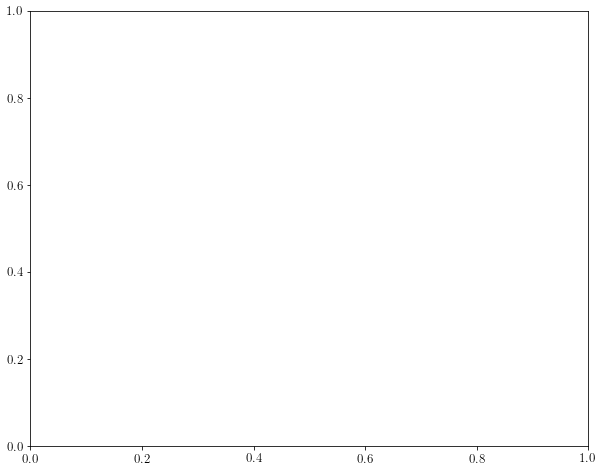

In [73]:
fig, ax = plt.subplots(figsize=(10,8))

In [74]:
nx.draw(G, pos=nx.spring_layout(G), node_size=20, node_color="black", width=0.5, ax=ax)

In [77]:
fig.savefig("US_interference_graph.pdf")

The plot above gives an idea of the distribution of sizes and density of the components.

In [59]:
largest_cc = max(nx.connected_components(G_raw), key=len)

**DEPRECATED:**

The US interference graph is connected, but quite parse, with a density of about 0.04. However, as will be seen later, the graph is far from regular. In highly-populated areas on the West and East Coast of the US the graph is much denser and it will be shown later that the tricky problems are here while station repacking in rural areas is trivial.

How the hell did this come?

# The restricted US interference graphs

This section studies the US interference restricted to channels 14 to 36, which were the available UHF channels for repacking in the final round of the auction. VHF and UHF channels do not interfere so the problems can be treated separately. It is, however, important to note that UHF stations can be repacking into the VHF band if necessary.

In [78]:
# Read pruned constraints
constraints = pd.read_csv(path_constraints, index_col = "Unnamed: 0")
constraints.loc[:, "interferingIDs"] = constraints.loc[:, "interferingIDs"].\
    apply(lambda x: listify_regex(x) if pd.notnull(x) else None)
constraints.loc[:, "targetID"] = constraints["targetID"].apply(str)
constraints.head()

interferenceType  targetChannel  interferingChannel targetID  \
68072               CO             14                  14       87   
68073               CO             14                  14      125   
68074               CO             14                  14      126   
68075               CO             14                  14      131   
68076               CO             14                  14      144   

                                          interferingIDs  
68072         [25382, 50170, 50182, 66222, 77480, 86532]  
68073  [126, 14040, 20476, 24514, 29455, 35037, 35883...  
68074  [125, 14040, 20476, 24514, 29455, 35037, 35883...  
68075  [4108, 5802, 6601, 6744, 7726, 7727, 9881, 100...  
68076  [6669, 8564, 9754, 9781, 12522, 12895, 17433, ...

In [79]:
constraints.shape

(119643, 5)

In [80]:
# Read pruned domains
domains = pd.read_csv(path_domains, index_col = "targetID")
domains["domain"] = domains["domain"].apply(listify)
domains.head()

domain
targetID                                                   
87        [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
125       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
126       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
131       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
144       [14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 2...

In [81]:
stationSet = set(constraints["targetID"].values)
V = stationSet
len(stationSet)

2058

When restricting our attention to channels 14-36 only 2058 stations are of interest. The rest do not have any of these channels in their domain and cannot be repacking to these channels.

Correct (we might also want to consider different, large subsets!)

In [82]:
#Create edge set
E = set()
for station in stationSet:
    interferingStations = _get_interfering_stations_fast(station, stationSet, constraints)
    for interferingStation in interferingStations:
        E.add((station, interferingStation)) #The graph is the same, but we want both orders in the edge set
            
len(E)

70194

There are 70194 edges in the interference graph on the 2058 stations that have non-empty intersections with channels 14 to 36.

In [83]:
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

In [84]:
cc_dict_pruned = dict()
cnt_nodes_pruned = 0

index_cnt_pruned = 0
ccs_pruned = (G.subgraph(cc) for cc in nx.connected_components(G))
for cc in ccs_pruned:
    cnt_nodes_pruned += nx.number_of_nodes(cc)
    cc_dict_pruned[index_cnt_pruned] = {"density": nx.density(cc),
                                 "size": nx.number_of_nodes(cc),
                                 "stations": set(cc)}
    index_cnt_pruned += 1
    
# A quick consistency check    
if cnt_nodes_pruned != len(V):
    raise ValueError("Some stations went missing")

cc_df_pruned = pd.DataFrame.from_dict(cc_dict_pruned, orient="index")
cc_df_pruned.head()

density  size                                           stations
0  0.027988  1458  {1000155, 61251, 36841, 52408, 77676, 52420, 3...
1  0.963235    17  {6823, 6359, 22215, 10177, 57884, 168495, 3582...
2  0.180652   174  {14000, 70900, 334, 69735, 35703, 19191, 2731,...
3  1.000000     4               {1500219, 1500220, 1500222, 1500221}
4  0.157207   104  {1000046, 62469, 1000055, 166534, 50591, 71078...

In [85]:
cc_df_pruned["type"] = cc_df_pruned.loc[:, ["density", "size"]].apply(lambda row: "isolated" if row["size"] == 1 \
                                                        else ("clique" if row["density"] == 1 else "no_type"), axis=1)

In [86]:
cc_df_pruned = cc_df_pruned.sort_values(by="size", ascending=False)
cc_df_pruned.head(10)

density  size                                           stations     type
0   0.027988  1458  {1000155, 61251, 36841, 52408, 77676, 52420, 3...  no_type
2   0.180652   174  {14000, 70900, 334, 69735, 35703, 19191, 2731,...  no_type
4   0.157207   104  {1000046, 62469, 1000055, 166534, 50591, 71078...  no_type
10  0.850640    38  {54443, 4077, 3001, 53859, 2245, 28954, 58341,...  no_type
5   0.460317    28  {1500137, 1000077, 1500132, 1000045, 1500130, ...  no_type
6   0.329004    22  {1000028, 1000022, 1500005, 1000018, 1000013, ...  no_type
21  1.000000    21  {1500345, 1500343, 1500356, 1500353, 1500361, ...   clique
13  0.915033    18  {37105, 34445, 664, 89714, 36920, 27969, 65395...  no_type
1   0.963235    17  {6823, 6359, 22215, 10177, 57884, 168495, 3582...  no_type
20  1.000000    16  {1500193, 1500195, 1500204, 1500200, 1500196, ...   clique

In [87]:
# write to csv for table.

In [88]:
cc_df_pruned[cc_df_pruned["type"] == "clique"]

density  size                                           stations    type
21      1.0    21  {1500345, 1500343, 1500356, 1500353, 1500361, ...  clique
20      1.0    16  {1500193, 1500195, 1500204, 1500200, 1500196, ...  clique
17      1.0    16  {1500066, 1500159, 1500069, 1500161, 1500164, ...  clique
11      1.0     9  {1500427, 1500428, 1500426, 1500430, 1500429, ...  clique
8       1.0     6  {1500324, 1500326, 1500327, 1500328, 1500329, ...  clique
35      1.0     5      {1500269, 1500268, 1500265, 1500266, 1500267}  clique
31      1.0     4                         {35655, 25221, 787, 49632}  clique
3       1.0     4               {1500219, 1500220, 1500222, 1500221}  clique
47      1.0     4               {1000121, 1000118, 1000120, 1000119}  clique
45      1.0     4               {1500051, 1500096, 1500050, 1500049}  clique
27      1.0     3                        {1000076, 1500259, 1000075}  clique
43      1.0     3                              {11699, 51479, 32177}  clique
30      1.0     3                              {18286, 63177, 74256}  clique
44      1.0     3                               {8263, 42640, 58618}  clique
23      1.0     3                              {14042, 31597, 71948}  clique
24      1.0     3                              {13813, 49621, 20015}  clique
34      1.0     3                        {1500292, 1500291, 1500290}  clique
55      1.0     2                                     {34846, 37103}  clique
50      1.0     2                                 {1500278, 1500279}  clique
51      1.0     2                                 {1500444, 1500443}  clique
56      1.0     2                                 {1500322, 1000109}  clique
36      1.0     2                                     {60740, 61335}  clique
29      1.0     2                                 {1500242, 1500243}  clique
25      1.0     2                                 {1500314, 1500313}  clique
12      1.0     2                                 {1000341, 1000340}  clique
28      1.0     2                                 {1500181, 1500182}  clique

In [89]:
cc_df_pruned.loc[:, "type"].value_counts()

clique      26
isolated    20
no_type     13
Name: type, dtype: int64

There are now several less components, mainly due to not considering VHF stations. The large component now is almost 1000 stations smaller, but a little more dense (0.027 instead of 0.021). There are also two other interesting components of interest, of sizes 104 and 174 with densities around 0.2. The rest of the components are either cliques, isolated stations or rather small.

### Degree histograms

In [90]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

In [91]:
degree_count = dict()
for degree in degree_sequence:
    if degree not in set(degree_count.keys()):
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1
        
for i in range(0, max(degree_sequence)+1):
    if i not in set(degree_count.keys()):
        degree_count[i] = 0
        
degree_count.values

<function dict.values>

In [102]:
keys = list(degree_count.keys())
keys.sort()
test = [(key, degree_count[key]) for key in keys]    

In [103]:
test

[(0, 20),
 (1, 34),
 (2, 35),
 (3, 41),
 (4, 30),
 (5, 25),
 (6, 25),
 (7, 33),
 (8, 49),
 (9, 40),
 (10, 25),
 (11, 25),
 (12, 18),
 (13, 34),
 (14, 32),
 (15, 59),
 (16, 47),
 (17, 21),
 (18, 19),
 (19, 17),
 (20, 39),
 (21, 17),
 (22, 39),
 (23, 51),
 (24, 19),
 (25, 37),
 (26, 30),
 (27, 30),
 (28, 44),
 (29, 31),
 (30, 35),
 (31, 40),
 (32, 34),
 (33, 36),
 (34, 24),
 (35, 36),
 (36, 36),
 (37, 34),
 (38, 23),
 (39, 26),
 (40, 27),
 (41, 27),
 (42, 33),
 (43, 24),
 (44, 24),
 (45, 29),
 (46, 22),
 (47, 22),
 (48, 21),
 (49, 18),
 (50, 15),
 (51, 18),
 (52, 18),
 (53, 18),
 (54, 24),
 (55, 23),
 (56, 18),
 (57, 16),
 (58, 28),
 (59, 20),
 (60, 20),
 (61, 18),
 (62, 19),
 (63, 19),
 (64, 18),
 (65, 18),
 (66, 9),
 (67, 14),
 (68, 12),
 (69, 10),
 (70, 18),
 (71, 9),
 (72, 13),
 (73, 10),
 (74, 14),
 (75, 7),
 (76, 7),
 (77, 3),
 (78, 6),
 (79, 7),
 (80, 3),
 (81, 9),
 (82, 4),
 (83, 5),
 (84, 4),
 (85, 6),
 (86, 7),
 (87, 4),
 (88, 5),
 (89, 4),
 (90, 1),
 (91, 2),
 (92, 1),
 (93, 1

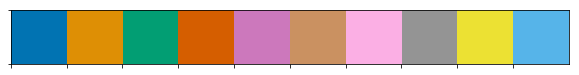

In [112]:
sns.palplot(current_palette)

#### Degree histogram of all G

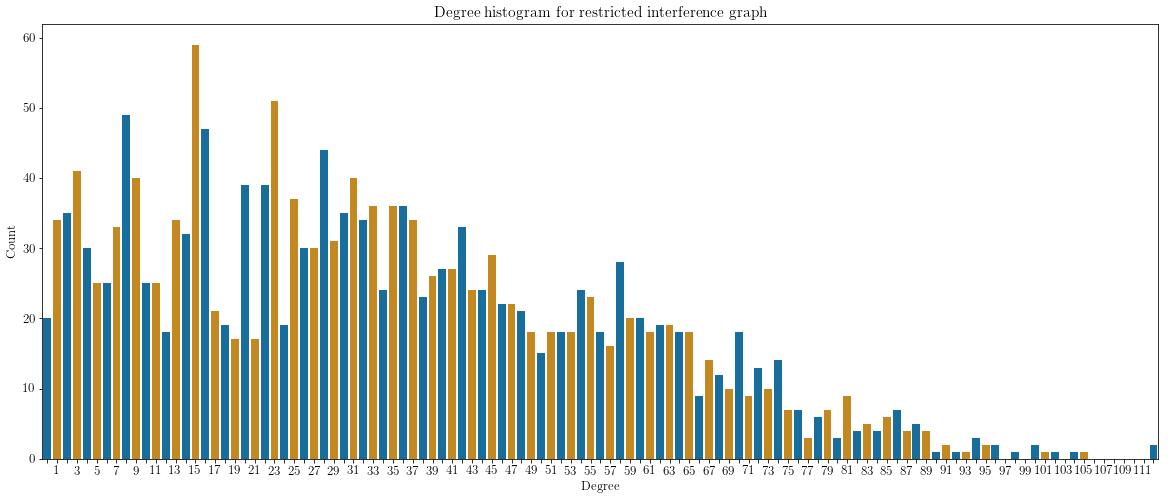

In [114]:
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.barplot(x=[x for (x,y) in test], y=[y for (x,y) in test], ci=None,
                palette=current_palette[0:2])

ax.set_title("Degree histogram for restricted interference graph")
ax.set(xlabel="Degree", ylabel="Count")
#ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels([x for (x,y) in test])
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
#Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
#pos = nx.spring_layout(G)
plt.axis('off')
#nx.draw_networkx_nodes(G, pos, node_size=20)
#nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.savefig("../reports/figures/degree_histogram.pdf")
plt.show()

#### Degree histogram of three largest CC's

In [120]:
cc_df_pruned.head()

density  size                                           stations     type
0  0.027988  1458  {77676, 48465, 190915, 21158, 1500366, 11909, ...  no_type
1  0.904762     7  {1000068, 1000099, 1500316, 1000058, 1500105, ...  no_type
2  0.180652   174  {67884, 191101, 4328, 43095, 81441, 36170, 357...  no_type
3  0.460317    28  {1500131, 1500132, 1500231, 1500127, 1500125, ...  no_type
4  0.157207   104  {5914, 1000052, 35187, 49264, 17402, 71080, 35...  no_type

In [121]:
large_ccs = (G.subgraph(cc) for cc in nx.connected_components(G) if len(cc) > 23)
largest_ccs = [cc for cc in large_ccs]

Here we will make degree histograms for the three components in one frame!

# Graph classes

## Perfect

## AT-free

See separate notebook

# Kernelized graph

Should we analyze the kernelized graph as well?

We should.. :-(

# Further questions

* Other properties to consider?
    * Strong connectedness
    * Diameter
    